1. Detect cracks in metallic/ceramic surfaces using classical image techniques

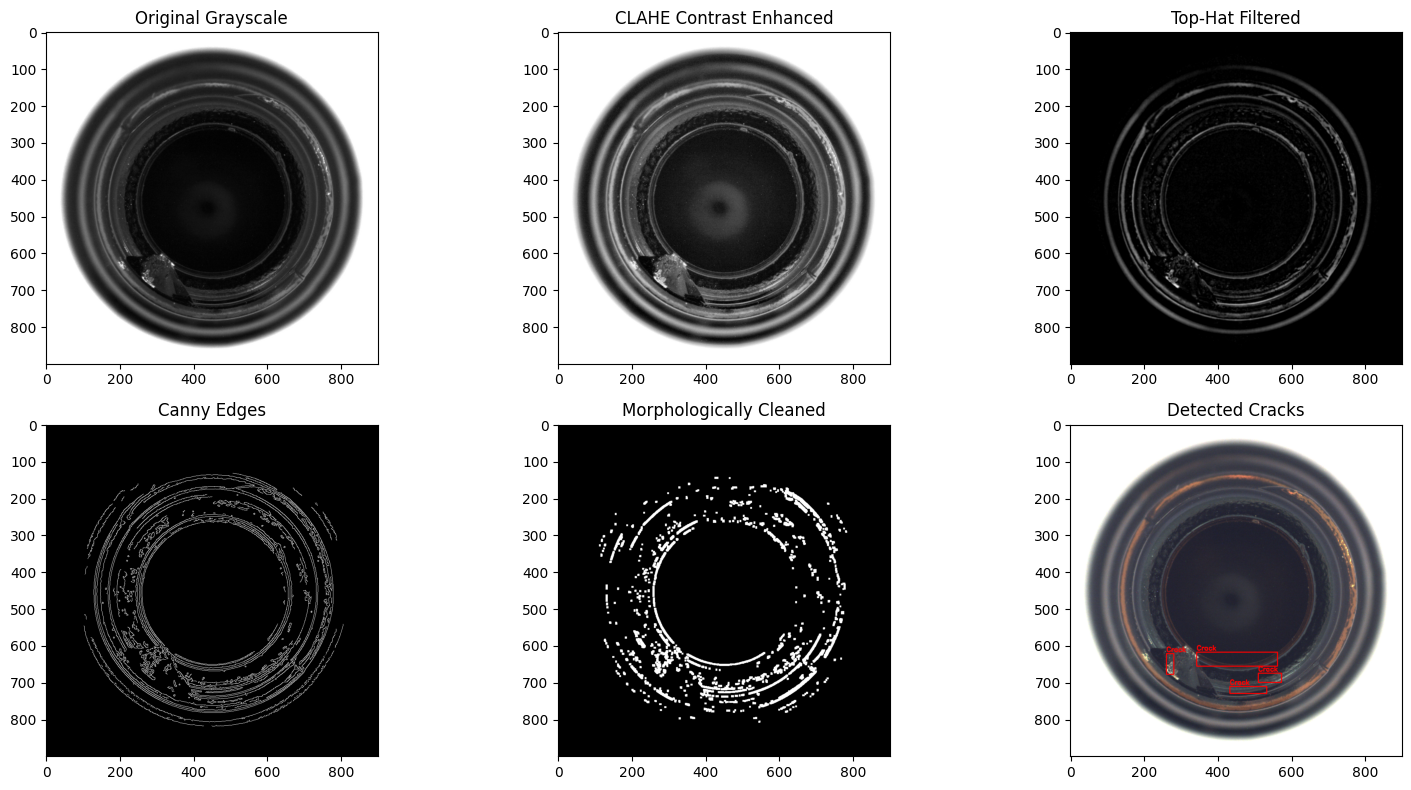

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

# ===================== 1. READ IMAGE =====================
# Load the image and convert to grayscale
img = cv2.imread("/content/005.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ===================== 2. CONTRAST ENHANCEMENT =====================
# CLAHE enhances local contrast to make subtle cracks more visible
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_eq = clahe.apply(gray)

# ===================== 3. NOISE SUPPRESSION =====================
# Gaussian blur reduces small texture noise but preserves edges
blur = cv2.GaussianBlur(gray_eq, (5,5), 0)

# ===================== 4. FEATURE ENHANCEMENT =====================
# Morphological Top-Hat: highlights dark cracks on brighter background
kernel_tophat = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
tophat = cv2.morphologyEx(blur, cv2.MORPH_TOPHAT, kernel_tophat)

# ===================== 5. EDGE DETECTION =====================
# Canny edge detector to extract crack edges
edges = cv2.Canny(tophat, 30, 90)

# ===================== 6. MORPHOLOGICAL CLEANUP =====================
# Remove tiny gaps and noise
kernel = np.ones((3,3), np.uint8)
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=1)
dilated = cv2.dilate(opened, kernel, iterations=1)

# ===================== 7. FIND CONTOURS =====================
# Extract connected candidate regions
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output = img.copy()

# ===================== 8. FILTERING BY SHAPE AND LENGTH =====================
for c in contours:
    area = cv2.contourArea(c)
    if area > 80:  # minimum area threshold
        x, y, w, h = cv2.boundingRect(c)
        aspect_ratio = max(w,h)/min(w,h)
        if aspect_ratio > 2.5:  # only elongated structures
            # Create a mask for skeleton analysis
            mask = np.zeros_like(dilated)
            cv2.drawContours(mask, [c], -1, 255, -1)
            skel = skeletonize(mask>0)
            length = skel.sum()
            if length > 30:  # reject very short segments
                # Draw rectangle and label
                cv2.rectangle(output, (x,y), (x+w,y+h), (0,0,255), 2)
                cv2.putText(output, "Crack", (x,y-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

# ===================== 9. VISUALIZATION =====================
plt.figure(figsize=(16,8))

plt.subplot(2,3,1)
plt.imshow(gray, cmap='gray')
plt.title("Original Grayscale")

plt.subplot(2,3,2)
plt.imshow(gray_eq, cmap='gray')
plt.title("CLAHE Contrast Enhanced")

plt.subplot(2,3,3)
plt.imshow(tophat, cmap='gray')
plt.title("Top-Hat Filtered")

plt.subplot(2,3,4)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edges")

plt.subplot(2,3,5)
plt.imshow(dilated, cmap='gray')
plt.title("Morphologically Cleaned")

plt.subplot(2,3,6)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Detected Cracks")

plt.tight_layout()
plt.show()


2. Detect the weld seam and flag discontinuities under noisy, site-like conditions.

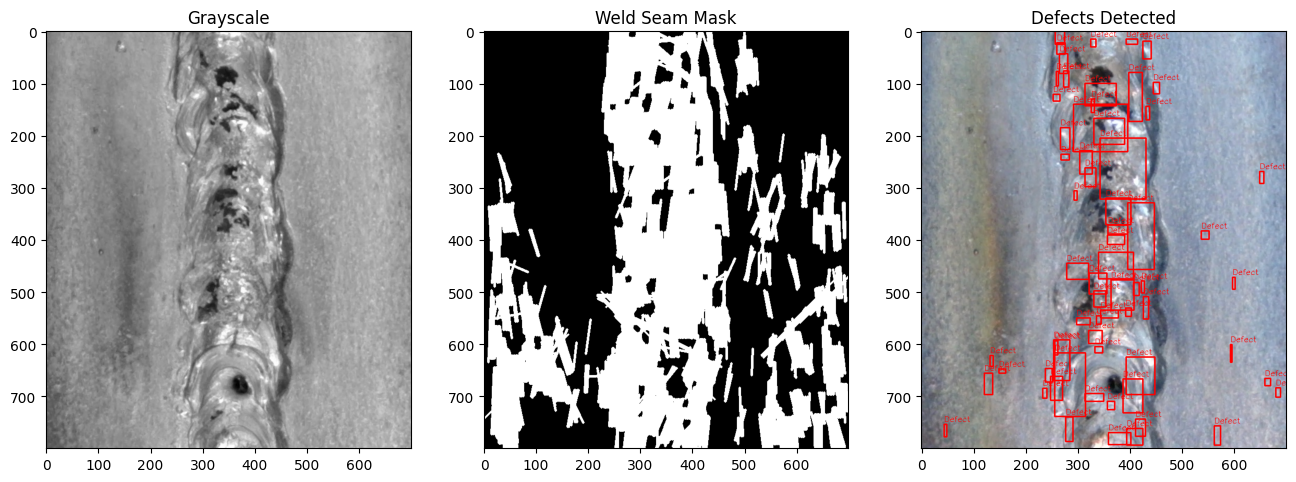

In [12]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

# ------------------- 1. Load image -------------------
img = cv2.imread("/content/weld.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ------------------- 2. Contrast + Denoise -------------------
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_eq = clahe.apply(gray)
blur = cv2.GaussianBlur(gray_eq, (5,5), 0)

# ------------------- 3. Weld seam extraction -------------------
# Edge detection
edges = cv2.Canny(blur, 50, 150)

# Morphology to connect seam edges
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)

# Optional: Hough line detection for straight seams
lines = cv2.HoughLinesP(closed, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)
seam_mask = np.zeros_like(gray)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(seam_mask, (x1, y1), (x2, y2), 255, 3)
else:
    # Fallback: use closed edges as seam mask
    seam_mask = closed

# ------------------- 4. Discontinuity enhancement -------------------
# Use top-hat to highlight dark discontinuities
kernel_tophat = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
tophat = cv2.morphologyEx(blur, cv2.MORPH_TOPHAT, kernel_tophat)

# Mask to seam region
discontinuity = cv2.bitwise_and(tophat, tophat, mask=seam_mask)

# Threshold to get candidate defects
_, defect_mask = cv2.threshold(discontinuity, 40, 255, cv2.THRESH_BINARY)

# Morphological cleaning
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
defect_clean = cv2.morphologyEx(defect_mask, cv2.MORPH_OPEN, kernel2, iterations=1)
defect_clean = cv2.morphologyEx(defect_clean, cv2.MORPH_CLOSE, kernel2, iterations=1)

# ------------------- 5. Skeletonize and filter -------------------
skel = skeletonize(defect_clean>0)
skel = (skel*255).astype(np.uint8)

# Filter by length (remove tiny noise)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(skel)
output = img.copy()
for i in range(1, num_labels):
    length = stats[i, cv2.CC_STAT_AREA]
    if length > 20:
        x, y, w, h = stats[i, cv2.CC_STAT_LEFT:cv2.CC_STAT_LEFT+4]
        cv2.rectangle(output, (x,y), (x+w,y+h), (0,0,255), 2)
        cv2.putText(output, "Defect", (x, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

# ------------------- 6. Visualization -------------------
plt.figure(figsize=(16,8))
plt.subplot(1,3,1); plt.imshow(gray, cmap='gray'); plt.title("Grayscale")
plt.subplot(1,3,2); plt.imshow(seam_mask, cmap='gray'); plt.title("Weld Seam Mask")
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB)); plt.title("Defects Detected")
plt.show()
